# Clustering Tecniques

### Import necessary libraries

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import fcluster
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

### Load dataset

In [2]:
user_details_data= pd.read_csv("/Users/akhilaannireddy/Projects/Machine_learning_project/Dataset/cleaned_user_data.csv")
user_details_data.head()

,user_id,display_name,reputation,profile_image,user_type,link,account_id,is_employee,last_modified_date,last_access_date,...,reputation_change_week,reputation_change_day,creation_date,accept_rate,badge_bronze,badge_silver,badge_gold,account_age_days,account_age_years,age_group
0,109,Kalid,22690,https://www.gravatar.com/avatar/5117b4aacf8b64...,registered,https://stackoverflow.com/users/109/kalid,91,False,2025-01-17 19:05:00,2015-10-10 21:32:52,...,10,0,2008-08-02 00:20:47,88.0,46,45,14,6029,16.5,15-18 Years
1,347807,CristiC,22688,https://www.gravatar.com/avatar/6023ac67694f90...,registered,https://stackoverflow.com/users/347807/cristic,141059,False,2024-04-09 05:40:03,2025-01-23 03:52:19,...,10,0,2010-05-22 13:10:40,96.0,89,61,13,5370,14.7,12-15 Years
2,3427777,fantabolous,22686,https://www.gravatar.com/avatar/34dac9c01fc709...,registered,https://stackoverflow.com/users/3427777/fantab...,4096755,False,2024-10-25 20:10:00,2024-12-09 04:11:00,...,0,0,2014-03-17 06:40:33,80.0,52,57,8,3976,10.9,10-12 Years
3,1858116,Gabriele Santomaggio,22682,https://i.sstatic.net/fQDZf.jpg?s=256,registered,https://stackoverflow.com/users/1858116/gabrie...,2087535,False,2023-12-25 15:00:00,2025-01-27 14:19:21,...,0,0,2012-11-27 23:02:03,78.0,59,58,4,4450,12.2,12-15 Years
4,13767,Rafał Rawicki,22680,https://www.gravatar.com/avatar/b043ead577679f...,registered,https://stackoverflow.com/users/13767/rafa%c5%...,7838,False,2024-05-08 11:00:00,2023-07-05 09:38:01,...,0,0,2008-09-16 20:48:13,88.0,79,63,5,5983,16.4,15-18 Years


In [3]:
print("Columns in the dataset")
print(user_details_data.columns)
print(user_details_data.dtypes)

Columns in the dataset
Index(['user_id', 'display_name', 'reputation', 'profile_image', 'user_type',
       'link', 'account_id', 'is_employee', 'last_modified_date',
       'last_access_date', 'reputation_change_year',
       'reputation_change_quarter', 'reputation_change_month',
       'reputation_change_week', 'reputation_change_day', 'creation_date',
       'accept_rate', 'badge_bronze', 'badge_silver', 'badge_gold',
       'account_age_days', 'account_age_years', 'age_group'],
      dtype='object')
user_id                        int64
display_name                  object
reputation                     int64
profile_image                 object
user_type                     object
link                          object
account_id                     int64
is_employee                     bool
last_modified_date            object
last_access_date              object
reputation_change_year         int64
reputation_change_quarter      int64
reputation_change_month        int64
reputatio

### Data Preprocessing

#### Removing age_group as Label for Clustering and Its Significance

The age_group column, which represents account age, is removed as the label before applying clustering to ensure that the model identifies natural groupings without any prior influence. By excluding this categorical variable, clustering can be performed purely based on numerical features such as reputation, badges, and activity metrics.

Later, the removed age_group labels can be used to evaluate how well the clustering results align with actual account longevity. This approach helps in identifying patterns in user engagement, grouping similar users based on their platform activity, and understanding how account age influences participation and reputation growth.

In [4]:
label = user_details_data["age_group"]
user_details_data = user_details_data.drop(columns=["age_group"])

label.to_csv("removed_labels.csv", index=False)


#### Selecting only numerical columns

In [5]:
user_details_data = user_details_data.select_dtypes(include=['number'])
print(user_details_data.info())
print(user_details_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104800 entries, 0 to 104799
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   user_id                    104800 non-null  int64  
 1   reputation                 104800 non-null  int64  
 2   account_id                 104800 non-null  int64  
 3   reputation_change_year     104800 non-null  int64  
 4   reputation_change_quarter  104800 non-null  int64  
 5   reputation_change_month    104800 non-null  int64  
 6   reputation_change_week     104800 non-null  int64  
 7   reputation_change_day      104800 non-null  int64  
 8   accept_rate                104800 non-null  float64
 9   badge_bronze               104800 non-null  int64  
 10  badge_silver               104800 non-null  int64  
 11  badge_gold                 104800 non-null  int64  
 12  account_age_days           104800 non-null  int64  
 13  account_age_years          10

#### Standardization

In [6]:
scaler = StandardScaler()
user_data_cleaned = scaler.fit_transform(user_details_data)
user_data_cleaned = pd.DataFrame(user_data_cleaned, columns=user_details_data.columns)
print("Standardized Data (Mean = 0, Variance = 1):")
user_data_cleaned.head()


Standardized Data (Mean = 0, Variance = 1):


,user_id,reputation,account_id,reputation_change_year,reputation_change_quarter,reputation_change_month,reputation_change_week,reputation_change_day,accept_rate,badge_bronze,badge_silver,badge_gold,account_age_days,account_age_years
0,-0.746956,0.336513,-0.632575,-0.078974,-0.078977,-0.078982,1.038494,-0.052008,0.751035,-0.215744,-0.020678,0.543694,1.399291,1.396006
1,-0.611990,0.336447,-0.591910,0.604144,0.604141,0.604137,1.038494,-0.052008,1.244211,0.314672,0.222459,0.462574,0.677366,0.676027
2,0.583562,0.336382,0.549195,0.064840,0.064837,0.064832,-0.219219,-0.052008,0.257860,-0.141732,0.161675,0.056972,-0.849740,-0.843928
3,-0.025733,0.336251,-0.030407,-0.294695,-0.294698,-0.294704,-0.219219,-0.052008,0.134566,-0.055386,0.176871,-0.267510,-0.330480,-0.323943
4,-0.741654,0.336185,-0.630340,0.064840,0.064837,0.064832,-0.219219,-0.052008,0.751035,0.191319,0.252851,-0.186390,1.348898,1.356007


In [7]:
# Saving the cleaned DataFrame as a CSV file
user_data_cleaned.to_csv("user_data_cleaned_for_clustering.csv", index=False)

print("CSV file saved successfully!")

CSV file saved successfully!


#### Applying PCA

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
user_data_pca = pca.fit_transform(user_data_cleaned)
user_data_pca = pd.DataFrame(user_data_pca, columns=[f"PC{i+1}" for i in range(6)])
explained_variance = np.sum(pca.explained_variance_ratio_) * 100
print(f"Variance retained after PCA - 6 components: {explained_variance:.2f}%")

Variance retained after PCA - 6 components: 95.24%


To evaluate the impact of dimensionality reduction on clustering, two versions of the dataset have been prepared. The first version, the original dataset, retains all numerical features after preprocessing, maintaining the full dimensionality of the data. The second version applies Principal Component Analysis (PCA) to reduce the dataset to six principal components while still preserving 95% of the original variance. By transforming the data, PCA helps eliminate redundancy and enhances computational efficiency. By using both datasets for clustering, their effectiveness in capturing meaningful patterns within the data can be compared. The PCA-transformed dataset may result in better-defined clusters due to reduced noise and lower dimensionality, while the original dataset retains all detailed information. The results from both approaches will help determine whether dimensionality reduction improves clustering accuracy or if retaining the full set of features provides better insights.

### K Means Clustering

#### Determine the Optimal k Using Silhouette Score

In [9]:
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(user_data_pca)
    score = silhouette_score(user_data_pca, cluster_labels)
    silhouette_scores.append(score)
best_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {best_k}")

# Ploting Silhouette Scores for different k values
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='g')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid(True)
plt.show()

Optimal Clustering at k=6: The highest silhouette score (~0.51) is observed at k=6, indicating that this is the most well-defined and cohesive clustering configuration.

Stable Performance for k=3 to k=6: The silhouette scores gradually increase from k=3 to k=6, suggesting that clustering remains stable and meaningful within this range.

Sharp Decline After k=6: A significant drop in silhouette score is seen at k=7 (~0.25), indicating that increasing the number of clusters beyond this point leads to poor clustering quality and weaker separation.

Poor Cluster Definition for k ≥ 7: The silhouette scores remain consistently low for k=7 to k=10, implying that additional clusters introduce more overlap and reduce the distinctiveness of groupings.


#### Apply K-Means for Selected k Values

In [10]:
# Selected k values from silhouette analysis
k_values = [3, 4, 5]
kmeans_models = {}
clustered_dataframes = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    user_data_pca[f'Cluster_k{k}'] = kmeans.fit_predict(user_data_pca)
    kmeans_models[k] = kmeans
    clustered_dataframes[k] = user_data_pca.copy()
    print(f"\nCluster Centers for k = {k}:")
    print(kmeans.cluster_centers_)


The clustering analysis using K-Means was applied to the PCA-transformed dataset to group users based on engagement patterns. Silhouette Analysis identified k=6 as the optimal number of clusters, leading to the evaluation of k=3, 4, and 5 for comparison. The cluster centers for each k-value revealed distinct patterns in user attributes such as reputation, activity metrics, and engagement levels.

For k=3, three well-separated clusters emerged—one representing highly active users and two capturing varying engagement levels. Increasing to k=4 and k=5 introduced finer divisions, capturing more nuanced user behaviors. Notably, for k=5, one cluster comprised users with exceptionally high reputation and activity, while others represented moderate contributors, illustrating how increasing k refines cluster granularity.

The clustered datasets were saved for further evaluation. The next step involves comparing clustering results with original labels and analyzing cluster characteristics to gain deeper insights into user engagement trends and behavioral segmentation.

### Visualize K-Means Clustering

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, k in enumerate(k_values):
    ax = axes[i]
    scatter = ax.scatter(user_data_pca["PC1"], user_data_pca["PC2"], 
                         c=user_data_pca[f'Cluster_k{k}'], cmap='viridis', alpha=0.6, edgecolors="k")
    centroids = kmeans_models[k].cluster_centers_
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    ax.set_title(f"K-Means Clustering (k={k})")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.legend(*scatter.legend_elements(), title="Clusters")

plt.tight_layout()
plt.show()

Impact of k-Values: As k increases from 3 to 5, clusters become more refined, capturing finer variations in user engagement patterns. k=3 results in broad groupings, while k=4 and k=5 provide more detailed segmentation.

Centroid Movement: Red Xs mark the cluster centroids, which shift as k increases, adapting to new cluster boundaries. This demonstrates K-Means’ ability to refine user segmentation dynamically.

Outliers and Spread: Some users lie far from main clusters, indicating unique engagement behaviors. With k=5, clustering becomes more granular, detecting highly active or inactive users.

Optimal k-Value: While k=3 provides broad engagement categories, k=4 and k=5 offer better-defined groups. Beyond k=5, clusters may become too specific, leading to overfitting.

Cluster Compactness: Clusters are tightly packed, indicating well-grouped users with similar engagement characteristics. Some overlap exists, especially at k=4 and k=5, suggesting shared attributes among mid-level users.

####  Compute Cluster Statistics

In [12]:
for k in k_values:
    print(f"\nCluster Statistics for k={k}:")
    print(user_data_pca.groupby(f'Cluster_k{k}').mean())


k=3: Users are segmented into low, moderate, and highly active groups. One cluster has significantly high engagement, while the others represent varying activity levels.

k=4: Introduces a more refined division, distinguishing moderate users with different engagement patterns from the original groups.

k=5: Further granularity captures high but inconsistent engagement, but risks over-segmentation, making clusters harder to interpret.

#### Compare with Original Labels

In [13]:
true_labels = pd.read_csv("removed_labels.csv") 
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels.values.ravel())
for k in k_values:
    print(f"\nConfusion Matrix for k={k}:")
    print(confusion_matrix(true_labels_encoded, user_data_pca[f'Cluster_k{k}']))

The confusion matrix results show how well K-Means clustering grouped users based on their account age.

For k=3, the model broadly grouped users but lacked clear separation, with most users concentrated in a few clusters. This suggests that three clusters were too general.

With k=4, clustering improved slightly, capturing more variations in account age. However, overlaps remained, particularly among middle-aged accounts, indicating that four clusters were still too broad.

For k=5, the clusters became more distinct, effectively segmenting users based on engagement and reputation. While some overlap persisted, this setup provided the best balance between separation and interpretability.

### Hierarchical Clustering

Hierarchical clustering is another clustering technique that builds a tree-like structure (dendrogram) to represent relationships between data points. Unlike K-Means, it does not require specifying the number of clusters in advance. The clusters are formed by either merging (agglomerative) or splitting (divisive) data points.

####  Load and Prepare Data

In [14]:
pca = PCA(n_components=6)
user_data_pca = pca.fit_transform(user_data_cleaned)
user_data_pca = pd.DataFrame(user_data_pca, columns=[f"PC{i+1}" for i in range(6)])
explained_variance = np.sum(pca.explained_variance_ratio_) * 100
print(f"Variance retained after PCA - 6 components: {explained_variance:.2f}%")

Variance retained after PCA - 6 components: 95.24%


#### Compute and Plot the Dendrogram

/var/folders/tr/rny836212c3czy_464g2sdjr0000gn/T/ipykernel_29632/1445423880.py:12: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(cosine_distance, method='complete')


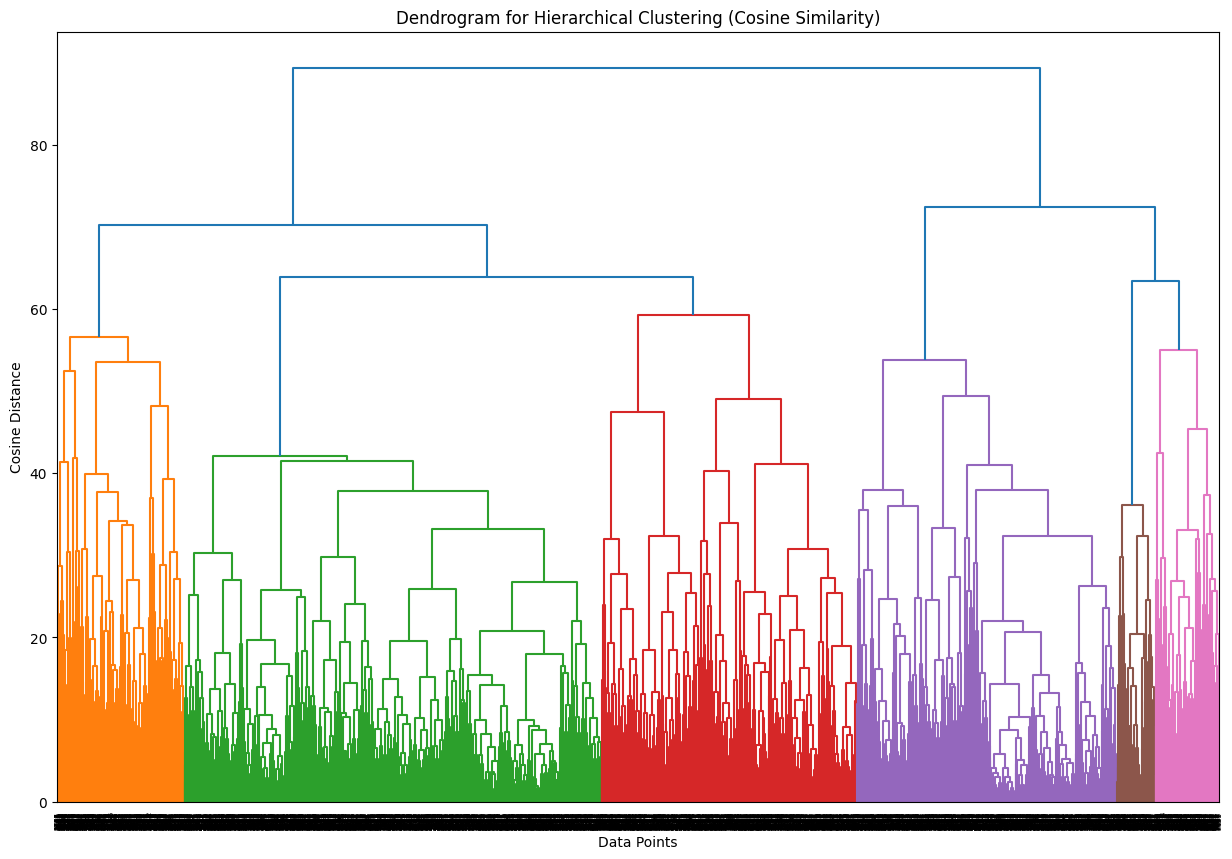

In [33]:
user_data_sample = user_data_pca.sample(n=5000, random_state=42)
cosine_distance = squareform(pdist(user_data_sample, metric='cosine'))
linkage_matrix = linkage(cosine_distance, method='complete')

plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix)
plt.title("Dendrogram for Hierarchical Clustering (Cosine Similarity)")
plt.xlabel("Data Points")
plt.ylabel("Cosine Distance")
plt.show()


Cluster Formation: Distinct clusters are highlighted in different colors.

Cosine Distance (Y-Axis): Lower values indicate higher similarity; large vertical branches show major cluster separations.

Densely Packed Clusters: The leftmost clusters (orange & green) are highly similar, merging at lower distances.

Widely Spaced Clusters: The rightmost clusters (purple & pink) merge at higher distances, indicating diverse user behaviors.

Optimal Clusters: Cutting the dendrogram at cosine distance ~60 suggests 5-6 well-separated clusters.

#### Choose the Number of Clusters & Extract Cluster Labels

In [17]:
num_clusters = 3
cluster_labels = fcluster(sch.linkage(user_data_sample, method='ward'), num_clusters, criterion='maxclust')
user_data_sample["Hierarchical_Cluster"] = cluster_labels

#### Visualize the Clusters

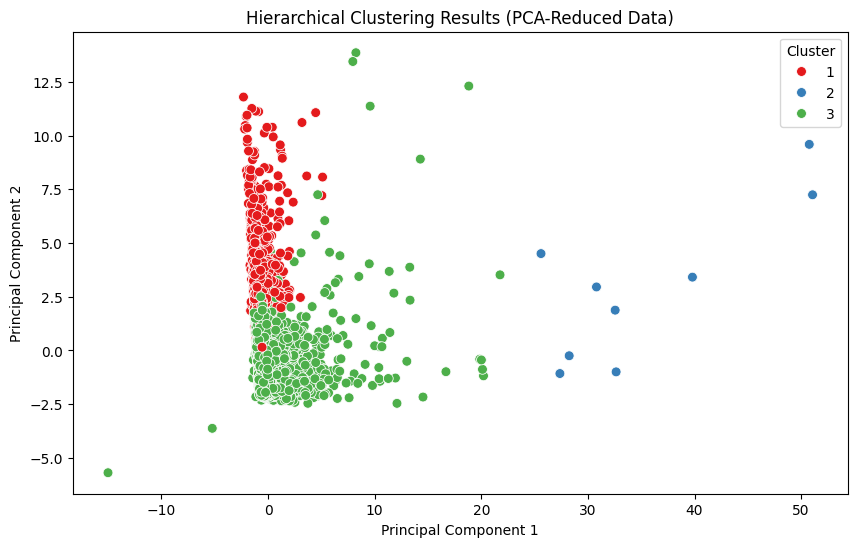

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=user_data_sample["PC1"], y=user_data_sample["PC2"], hue=user_data_sample["Hierarchical_Cluster"], palette="Set1", s=50)
plt.title("Hierarchical Clustering Results (PCA-Reduced Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()


The hierarchical clustering plot shows three distinct clusters. The red (Cluster 1) and green (Cluster 3) groups are densely packed, while the blue cluster (Cluster 2) consists of widely spread points, which may be outliers. The vertical alignment of Clusters 1 and 3 suggests that most variation is along Principal Component 2, meaning the key differences between these groups might be in specific features compressed by PCA. Cluster 2 is far from the others, indicating it might contain very different data points or potential outliers. To improve clustering, you could refine the number of clusters, analyze outliers, and compare results with K-Means clustering.

### DBSCAN

###  Determine the Optimal eps using K-Distance Plot

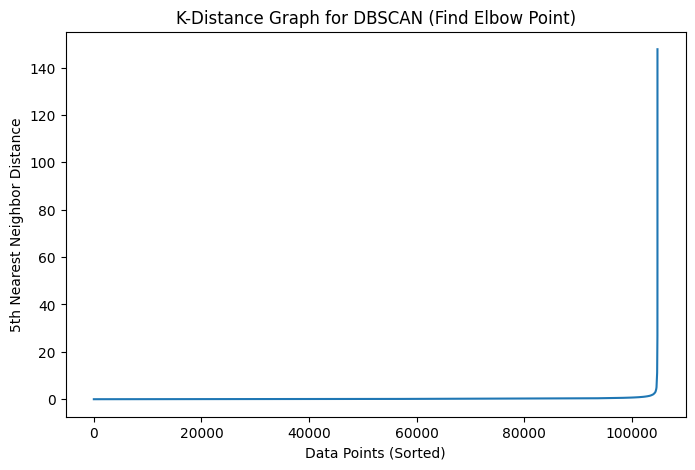

In [27]:
X = user_data_pca
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Data Points (Sorted)")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("K-Distance Graph for DBSCAN (Find Elbow Point)")
plt.show()

The K-Distance Graph is used to determine the optimal eps value for DBSCAN clustering. It plots the distance to the 5th nearest neighbor for each data point, sorted in ascending order.

Flat Region at the Start: The graph remains relatively stable for most data points, indicating that these points are densely packed and have small nearest-neighbor distances.

Sharp Increase at the End: A steep rise is observed at the far right, representing points that are more isolated and farther from their neighbors. This transition is known as the elbow point.

Identifying eps: The ideal eps value for DBSCAN is chosen just before this sharp increase, ensuring that the algorithm effectively distinguishes between core points and noise.

### Apply DBSCAN with the Determined eps and min_samples

In [28]:
eps_value = 0.5
min_samples_value = 2 * X.shape[1]
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value, metric="euclidean")
user_data_pca["cluster"] = dbscan.fit_predict(X)
print("Cluster counts:\n", user_data_pca["cluster"].value_counts())
num_outliers = (user_data_pca["cluster"] == -1).sum()
print(f"Number of outliers detected: {num_outliers}")

Cluster counts:
 cluster
 1     88398
-1      9408
 0      6686
 3       103
 2        83
 9        15
 8        14
 6        13
 11       13
 7        13
 12       12
 4        12
 5        11
 10       10
 13        9
Name: count, dtype: int64
Number of outliers detected: 9408


DBSCAN identified a dominant cluster, with most data points grouped under Cluster 1 (88,398 points). A significant number of outliers (9,408 points) were detected, indicating potential anomalies or noise in the dataset. The second-largest cluster, Cluster 0, contains 6,686 points, while other clusters have relatively small counts, with a few containing fewer than 20 points.

This clustering approach effectively distinguishes dense regions, isolates noise, and highlights smaller meaningful clusters, providing valuable insights into the dataset's structure.

###  Visualizing DBSCAN Clusters

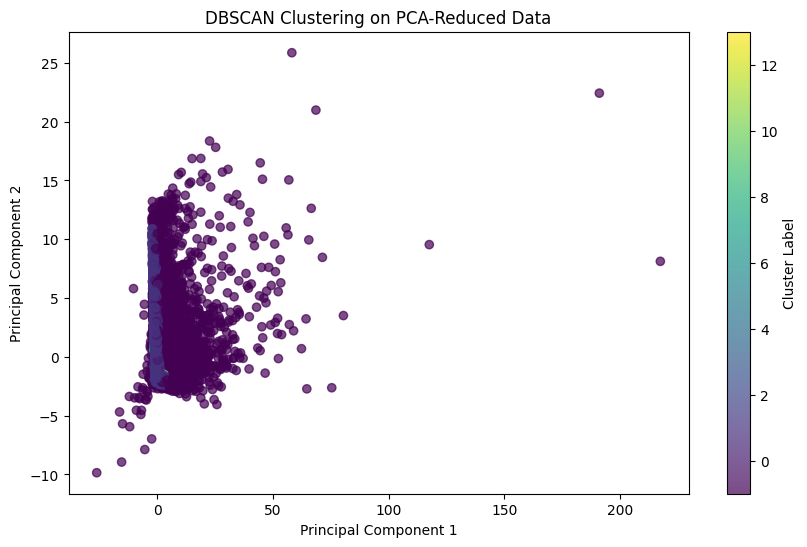

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(user_data_pca.iloc[:, 0], user_data_pca.iloc[:, 1], c=user_data_pca["cluster"], cmap="viridis", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("DBSCAN Clustering on PCA-Reduced Data")
plt.colorbar(label="Cluster Label")
plt.show()

This visualization shows DBSCAN clustering on PCA-reduced data, with the first two principal components on the axes.

Cluster Formation: Multiple clusters are detected, with colors representing different labels.

Outliers & Noise: Scattered points indicate noise (-1 cluster), effectively separated by DBSCAN.

Dense Core: Most data points form a compact cluster, suggesting strong grouping.

Vertical Spread: The distribution shows data is concentrated in a narrow PC1 range.